Reference Notebooks:


## Import libraries

In [ ]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, Add, GRU

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load source datasets

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/IOT+AI : SRM - NITW/Google Ventilator Predictor/Data/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/IOT+AI : SRM - NITW/Google Ventilator Predictor/Data/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [ ]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")

    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")

    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")

    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")

    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']

    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")

    # df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    # df['ewm_u_in_mean'] = (df\
    #                        .groupby('breath_id')['u_in']\
    #                        .ewm(halflife=9)\
    #                        .mean()\
    #                        .reset_index(level=0,drop=True))
    # df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
    #                                                           .groupby('breath_id')['u_in']\
    #                                                           .rolling(window=15,min_periods=1)\
    #                                                           .agg({"15_in_sum":"sum",
    #                                                                 "15_in_min":"min",
    #                                                                 "15_in_max":"max",
    #                                                                 "15_in_mean":"mean"})\
    #                                                            .reset_index(level=0,drop=True))
    # print("Step-6...Completed")

    # df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    # df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    # df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    # df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    # print("Step-7...Completed")

    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")

    return df


print("Train data...\n")
train = add_features(train_df)
del train_df
gc.collect()
print("\nTest data...\n")
test = add_features(test_df)


del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-8...Completed


0

In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 54) 
test: (4024000, 54)


In [ ]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 54) 
test: (50300, 80, 54) 
targets: (75450, 80)


In [ ]:
pressure = targets.squeeze().reshape(-1,1).astype('float32')

P_MIN = np.min(pressure)
P_MAX = np.max(pressure)
P_STEP = (pressure[1] - pressure[0])[0]
print('Min pressure: {}'.format(P_MIN))
print('Max pressure: {}'.format(P_MAX))
print('Pressure step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(pressure).shape[0]))

del pressure
gc.collect()

Min pressure: -1.8957443237304688
Max pressure: 64.82099151611328
Pressure step: 0.07030248641967773
Unique values:  950


22

## Hardware config

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")

except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


## Keras DNN Model

In [ ]:
def dnn_model1():

    x_input = Input(shape=(train.shape[-2:]))

    x1 = Bidirectional(GRU(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(GRU(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(GRU(units=256, return_sequences=True))(x2)

    z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
    z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))

    x = Concatenate(axis=2)([x3, z2, z3])
    x = Bidirectional(GRU(units=192, return_sequences=True))(x)

    x = Dense(units=240, activation='tanh')(x)

    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output,
                  name='DNN_Model')
    return model

In [ ]:
def dnn_model():

    x_input = Input(shape=(train.shape[-2:]))

    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=256, return_sequences=True))(x2)

    z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
    z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))

    x = Concatenate(axis=2)([x3, z2, z3])
    x = Bidirectional(LSTM(units=192, return_sequences=True))(x)

    x = Dense(units=128, activation='tanh')(x)

    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output,
                  name='DNN_Model')
    return model

In [ ]:
model = dnn_model1()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 54)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 80, 1536)     3796992     ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 80, 1024)    6297600     ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 80, 512)     1969152     ['bidirectional_1[0][0]']

In [ ]:
model = cnn_model()
model.summary()

NameError: name 'cnn_model' is not defined

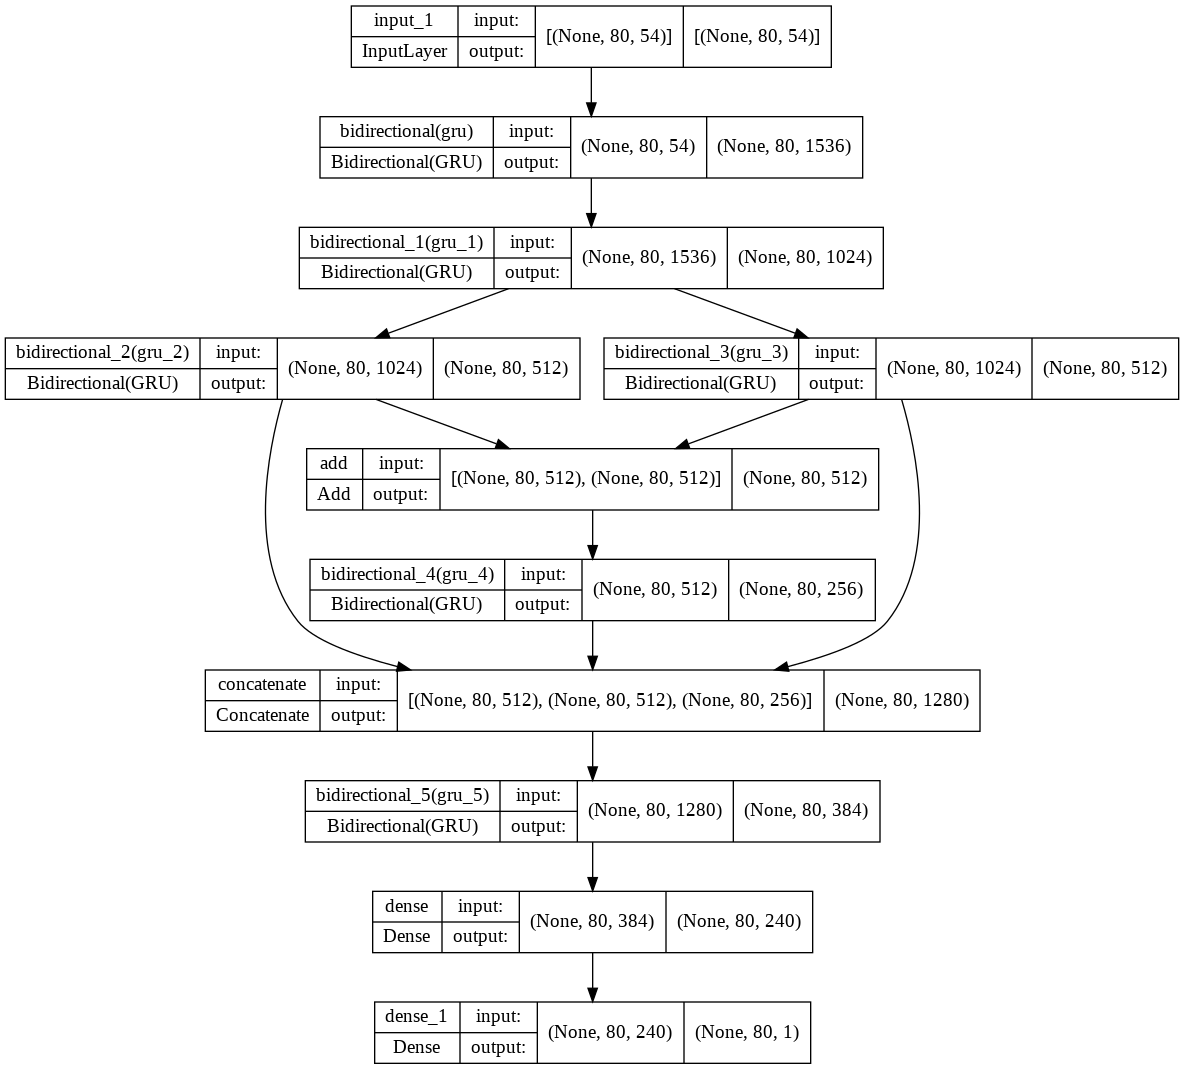

In [ ]:
plot_model(
    model,
    to_file='Google_Brain_Keras_Model.png',
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
with tpu_strategy.scope():

    VERBOSE = 0
    test_preds = []
    kf = KFold(n_splits=7, shuffle=True, random_state=2021)

    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]

        model = dnn_model1()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75,
                               patience=10, verbose=VERBOSE)

        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=save_locally,
                                    monitor='val_loss', verbose=VERBOSE,
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50,
                           verbose=VERBOSE, mode="min",
                           restore_best_weights=True)

        model.fit(X_train, y_train,
                  validation_data=(X_valid, y_valid),
                  epochs=400,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE,
                  callbacks=[lr, chk_point, es])

        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=load_locally)

        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")

        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

NameError: ignored

In [ ]:
for i in range(7):
    print(test_preds[i][0])

len(test_preds)

## Create submission file

In [ ]:
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/7
submission.to_csv('mean_submission.csv', index=False)